In [107]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc
import json
import cv2
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [108]:
# From Valhallavagen_grid.png
Valhallavagen_X_min = -10.75
Valhallavagen_X_max = 10.75
Valhallavagen_Y_min = -38.27
Valhallavagen_Y_max = 38.27

Valhallavagen_env_vectors = {
    'Type': ['Lane', 'Lane', 'Lane', 'Lane', 'SideWalk', 'SideWalk', 'SideWalk', 'SideWalk', 'PreCrosswalk', 'PreCrosswalk', 'CrossWalk'],
    'Top_Left': [(225, 2), (289, 7), (174, 694), (227, 705), (195, 1), (121, 695), (355, 10), (295, 696), (138, 572), (313, 596), (184, 585)],
    'Top_Right': [(289, 7), (354, 12), (227, 705), (289, 707), (225, 2), (171, 707), (429, 15), (354, 703), (186, 585), (368, 599), (305, 603)],
    'Bottom_Left': [(193, 550), (245, 551), (55, 1486), (115, 1498), (140, 541), (1, 1471), (317, 547), (190, 1514), (129, 635), (300, 684), (177, 669)],
    'Bottom_Right': [(245, 551), (308, 558), (115, 1498), (186, 1513), (191, 545), (53, 1485), (377, 551), (267, 1530), (177, 641), (360, 689), (295, 684)],
    'Top_Left_to_Top_Right': [(64, 5), (65, 5), (53, 11), (62, 2), (30, 1), (50, 12), (74, 5), (59, 7), (48, 13), (55, 3), (121, 18)],
    'Top_Right_to_Bottom_Right': [(-44, 544), (-46, 546), (-112, 793), (-103, 806), (-34, 543), (-118, 778), (-52, 536), (-87, 827), (-9, 56), (-8, 90), (-10, 81)],
    'Bottom_Right_to_Bottom_Left': [(-52, -1), (-63, -7), (-60, -12), (-71, -15), (-51, -4), (-52, -14), (-60, -4), (-77, -16), (-48, -6), (-60, -5), (-118, -15)],
    'Bottom_Left_to_Top_Left': [(32, -548), (44, -544), (119, -792), (112, -793), (55, -540), (120, -776), (38, -537), (105, -818), (9, -63), (13, -88), (7, -84)]
}

valhallavagen_ENV = {
    'Type': [
        'Lane', 'Lane', 'Lane', 'Lane', 
        'SideWalk', 'SideWalk', 'SideWalk', 'SideWalk',
        'PreCrosswalk', 'PreCrosswalk', 'CrossWalk', 
        
        ],
    'Top_Left': [
        (225, 2), (289, 7), (174, 694), (227, 705), 
        (195, 1), (121, 695), (355, 10), (295, 696), 
        (138, 572), (313, 596), (184, 585) 
        ],
    'Top_Right': [
        (289, 7), (354, 12), (227, 705), (289, 707), 
        (225, 2), (171, 707), (429, 15), (354, 703),
        (186, 585), (368, 599), (305, 603)
        ],
    'Bottom_Left': [
        (193, 550), (245, 551), (55, 1486), (115, 1498), 
        (140, 541), (1, 1471), (317, 547), (190, 1514),
        (129, 635), (300, 684), (177, 669)
        ],
    'Bottom_Right': [
        (245, 551), (308, 558), (115, 1498), (186, 1513), 
        (191, 545), (53, 1485), (377, 551), (267, 1530),
        (177, 641), (360, 689), (295, 684)
        ]
}

valhallavagen_static_objs = {
    'Type': ['Pole', 'Pole', 'Pole', 'Pole'],
    'Top_Left': [(166, 674), (180, 573), (325, 583), (311, 690)],
    'Top_Right': [None] * 4,
    'Bottom_Left': [None] * 4,
    'Bottom_Right': [None] * 4
}

# From Torpagatan_grid.png
Torpagatan_X_min = -30.02 
Torpagatan_X_max = 30.02
Torpagatan_Y_min = -20
Torpagatan_Y_max = 20

Torpagatan_env_vectors = {
    'Type': ['Zebra Crossing', 'PreCrosswalk', 'PreCrosswalk', 'PreCrosswalk', 'PreCrosswalk', 'CrossWalk', 'Lane', 'Lane', 'Lane', 'Lane', 'Lane', 'Lane', 'SideWalk', 'SideWalk', 'SideWalk', 'SideWalk'],
    'Top_Left': [(428, 261), (126, 80), (386, 143), (434, 218), (391, 387), (253, 97), (482, 285), (464, 353), (124, 85), (94, 159), (259, 23), (318, 20), (50, 282), (450, 152), (391, 41), (446, 482)],
    'Top_Right': [(482, 285), (259, 23), (450, 152), (509, 228), (452, 409), (386, 143), (1293, 572), (1269, 625), (428, 261), (418, 329), (318, 20), (391, 41), (367, 442), (1340, 468), (446, 59), (1220, 736)],
    'Bottom_Left': [(391, 387), (202, 142), (384, 204), (428, 261), (337, 521), (202, 142), (464, 353), (452, 409), (94, 159), (70, 222), (253, 97), (311, 115), (30, 332), (509, 228), (386, 143), (458, 602)],
    'Bottom_Right': [(452, 409), (253, 97), (512, 224), (482, 285), (416, 549), (384, 204), (1269, 625), (1245, 679), (418, 329), (391, 387), (311, 115), (386, 143), (337, 521), (1320, 507), (450, 152), (1176, 831)],
    'Top_Left_to_Top_Right': [(54, 24), (133, -57), (64, 9), (75, 10), (61, 22), (133, 46), (811, 287), (805, 272), (304, 176), (324, 170), (59, -3), (73, 21), (317, 160), (890, 316), (55, 18), (774, 254)],
    'Top_Right_to_Bottom_Right': [(-30, 124), (-6, 74), (62, 72), (-27, 57), (-36, 140), (-2, 61), (-24, 53), (-24, 54), (-10, 68), (-27, 58), (-7, 95), (-5, 102), (-30, 79), (-20, 39), (4, 93), (-44, 95)],
    'Bottom_Right_to_Bottom_Left': [(-61, -22), (-51, 45), (-128, -20), (-54, -24), (-79, -28), (-182, -62), (-805, -272), (-793, -270), (-324, -170), (-321, -165), (-58, -18), (-75, -28), (-307, -189), (-811, -279), (-64, -9), (-718, -229)],
    'Bottom_Left_to_Top_Left': [(37, -126), (-76, -62), (2, -61), (6, -43), (54, -134), (51, -45), (18, -68), (12, -56), (30, -74), (24, -63), (6, -74), (7, -95), (20, -50), (-59, -76), (5, -102), (-12, -120)]
}

torpagatan_ENV = {
    'Type': [
        "Zebra Crossing", "PreCrosswalk", "PreCrosswalk", "PreCrosswalk", 
        "PreCrosswalk", "CrossWalk", "Lane", "Lane", "Lane", "Lane", 
        "Lane", "Lane", "SideWalk", "SideWalk", "SideWalk", "SideWalk"
        ],
    'Top_Left': [
        (428, 261), (126, 80), (386, 143), (434, 218), (391, 387), (253, 97), 
        (482, 285), (464, 353), (124, 85), (94, 159), (259, 23), (318, 20), 
        (50, 282), (450, 152), (391, 41), (446, 482)
        ],
    'Top_Right': [
        (482, 285), (259, 23), (450, 152), (509, 228), (452, 409), (386, 143), 
        (1293, 572), (1269, 625), (428, 261), (418, 329), (318, 20), (391, 41), 
        (367, 442), (1340, 468), (446, 59), (1220, 736)
        ],
    'Bottom_Left': [
        (391, 387), (202, 142), (384, 204), (428, 261), (337, 521), (202, 142),
        (464, 353), (452, 409), (94, 159), (70, 222), (253, 97), (311, 115), 
        (30, 332), (509, 228), (386, 143), (458, 602)
        ],
    'Bottom_Right': [
        (452, 409), (253, 97), (512, 224), (482, 285), (416, 549), (384, 204), 
        (1269, 625), (1245, 679), (418, 329), (391, 387), (311, 115),
        (386, 143), (337,521), (1320, 507), (450, 152), (1176, 831)
        ]
}

torpagatan_static_objs = {
    'Type': ["Tree", "Tree", "Tree", "Tree", "Sign", "Sign", "Sign"],
    'Top_Left': [(693, 629), (194, 342), (78, 261), (1047, 449), (500, 279), (380, 401), (439, 106)],
    'Top_Right': [None] * 7,
    'Bottom_Left': [None] * 7,
    'Bottom_Right': [None] * 7
}

torp_img = '../data/BaseImages/Torpagatan.png'
val_img = '../data/BaseImages/Valhallavagen.png'

# Dictionary to map object types to their respective IDs
moving_object_id = {'pedestrian': 0, 'bicyclist': 1, 'light_vehicle': 2, 'heavy_vehicle': 3}
# Dictionary to map IDs to descriptive names
moving_object_str = {0: 'Pedestrian', 1: 'Bicyclist', 2: 'Light Motor Vehicle', 3: 'Heavy Motor Vehicle'}


In [109]:
def get_location_values( min_x : float, max_x : float, min_y : float, max_y : float, img : str):

    base = plt.imread(img)
        
    # Calculate location dimensions in meters
    size_X = max_x - min_x
    size_Y = max_y - min_y

    print("SIZE: ", size_X, size_Y)

    # Get image dimensions in pixels
    img_size_X = base.shape[1]
    img_size_y = base.shape[0]
    print("IMG SIZE: ", img_size_X, img_size_y)

    del base
    gc.collect()

    # Compute origin and scaling factors for coordinate transformations
    origin_X = img_size_X * (-min_x) / size_X
    origin_Y = img_size_y * (-min_y) / size_Y
    print("ORIGIN: ", origin_X, origin_Y)

    scale_X = img_size_X / size_X
    scale_y = img_size_y / size_Y
    print("SCALE", scale_X, scale_y)
    
    return size_X, size_Y, img_size_X, img_size_y, origin_X, origin_Y, scale_X, scale_y

In [110]:
def combine_datasets(location_name : str):
    """
    Combines multiple days of trajectory data into a single DataFrame.

    Returns:
        DataFrame: Concatenated DataFrame containing data from all days.
    """
    # Read and combine data files
    df1 = pd.read_csv(f'../data/Original/{location_name}/2023-05-23.csv', sep=';')
    df2 = pd.read_csv(f'../data/Original/{location_name}/2023-05-24.csv', sep=';')
    df3 = pd.read_csv(f'../data/Original/{location_name}/2023-05-25.csv', sep=';')
    df4 = pd.read_csv(f'../data/Original/{location_name}/2023-05-26.csv', sep=';')
    
    df = pd.concat([df1, df2, df3, df4], ignore_index=True)
    del df1, df2, df3, df4
    gc.collect()
    return df

In [111]:
def create_dataset(location_name : str, origin_X : float, origin_Y : float, scale_X : float, scale_y : float):
    """
    Processes and transforms raw trajectory data into a usable format.

    Returns:
        DataFrame: Processed DataFrame containing trajectory data with scaled coordinates and floored timestamps.
    """
    file = Path(f'../data/CombinedData/{location_name}/data.csv')
        
    if file.exists():
        # Retrieve trajectory data
        return pd.read_csv(file, sep=',')
    
    # Combine datasets
    data = combine_datasets(location_name)

    # Preprocess column names and drop unnecessary ones
    data = data.rename(columns={'Speed, km/h': 'Speed'})
    data = data.drop(columns=['ID in database', 'Station', 'Estimated', 'Vx, m/s', 'Vy, m/s'])

    print("Preprocessing Data")

    # Convert Time to datetime and floor to 100ms in a vectorized way
    data['Time'] = pd.to_datetime(data['Time'], format='mixed', utc=True).dt.tz_localize(None).dt.floor('100ms')

    # Scale coordinates directly
    data['X'] = scale_X * data['X'] + origin_X
    data['Y'] = scale_y * data['Y'] + origin_Y

    # Group by ID and Time, calculate mean for numeric columns
    grouped = data.groupby(['ID', 'Time'], as_index=False).agg({
        'X': 'mean',
        'Y': 'mean',
        'Speed': 'mean',
        'Type': 'first'
    })

    # Sort values by Time
    grouped = grouped.sort_values(by='Time')

    # Optimize memory by converting to lower-precision types
    grouped['X'] = grouped['X'].astype('float32')
    grouped['Y'] = grouped['Y'].astype('float32')
    grouped['Speed'] = grouped['Speed'].astype('float32')
    grouped['ID'] = grouped['ID'].astype('int')
    grouped['Type'] = grouped['Type'].astype('int')

    # Save the processed data
    output_path = f'../data/CombinedData/{location_name}/data.csv'
    grouped.to_csv(output_path, index=False)

    return grouped

In [112]:
def max_num_agents(df):
    """
    Finds the maximum number of agents present in a single frame.

    Returns:
        int: Maximum number of agents in any given timestamp.
    """
    timestamp_counts = df.groupby('Time').size()
    max_count = timestamp_counts.max()
    del timestamp_counts
    gc.collect()
    return max_count

In [113]:
def visualize_all_trajectories(df, img, location_name):
    """
    Visualizes and saves the trajectories of all agents (pedestrians, bicyclists, light and heavy vehicles)
    on the map. Creates subplots for each agent type and saves the plot as an image.
    """
    # Filter the dataframe by types of objects (pedestrians, bicyclists, etc.)
    pedestrians = df[df.Type == moving_object_id['pedestrian']]
    bicyclists = df[df.Type == moving_object_id['bicyclist']]
    lightVeh = df[df.Type == moving_object_id['light_vehicle']]
    heavyVeh = df[df.Type == moving_object_id['heavy_vehicle']]

    # Group by 'ID' for each object type to track individual trajectories
    pedestrian_traj = pedestrians.groupby('ID')
    bicycle_traj = bicyclists.groupby('ID')
    lightVeh_traj = lightVeh.groupby('ID')
    heavyVeh_traj = heavyVeh.groupby('ID')

    # Count the number of distinct agents in each category
    pedestrian_count = pedestrian_traj.ngroups
    bicycle_count = bicycle_traj.ngroups
    light_vehicle_count = lightVeh_traj.ngroups
    heavy_vehicle_count = heavyVeh_traj.ngroups

    # Write these counts to a metadata file
    with open(f'../data/CombinedData/{location_name}/agent_info.txt', 'w') as f:
        f.write(f"The number of pedestrian: {pedestrian_count}\n")
        f.write(f"The number of bicycles: {bicycle_count}\n")
        f.write(f"The number of light vehicles: {light_vehicle_count}\n")
        f.write(f"The number of heavy vehicles: {heavy_vehicle_count}\n")

    # Create a subplot for each agent type
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle('All Agent Trajectories', fontsize=14)

    # Set titles and display images for each subplot
    axes[0].set_title('Pedestrian')
    axes[0].imshow(img, cmap='gray')

    axes[1].set_title('Light Vehicle')
    axes[1].imshow(img, cmap='gray')

    axes[2].set_title('Bike')
    axes[2].imshow(img, cmap='gray')

    axes[3].set_title('Heavy Vehicle')
    axes[3].imshow(img, cmap='gray')

    # Plot trajectories for each agent type
    for _, track in pedestrian_traj:
        axes[0].plot(track.X, track.Y, '-r', linewidth=0.2)

    for _, track in lightVeh_traj:
        axes[1].plot(track.X, track.Y, '-b', linewidth=0.2)

    for _, track in bicycle_traj:
        axes[2].plot(track.X, track.Y, '-g', linewidth=0.2)

    for _, track in heavyVeh_traj:
        axes[3].plot(track.X, track.Y, '-w', linewidth=0.2)

    # Adjust layout and save the image
    plt.tight_layout()
    plt.savefig(f"../data/CombinedData/{location_name}/all_traj.png")

In [114]:
def visualize_counts(df, location_name):
    """
    Visualizes and saves a bar chart of the counts for each type of agent (pedestrian, vehicle, etc.)
    in the location's data. The counts are based on unique 'ID' and 'Type' combinations.
    """
    # Create a new DataFrame with unique combinations of 'ID' and 'Type'
    unique_df = df.drop_duplicates(subset=['ID', 'Type'])

    # Count the occurrences of each type in the unique DataFrame
    type_counts = unique_df['Type'].value_counts().reset_index()
    type_counts.columns = ['Type', 'Count']

    # Map type IDs to descriptive labels
    type_counts['Type'] = type_counts['Type'].map(moving_object_str)

    # Create and save a bar plot of the type counts
    plt.figure(figsize=(10, 6))
    plt.bar(type_counts['Type'], type_counts['Count'], color='skyblue')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.title(f'Counts of Each Type {location_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"../data/CombinedData/{location_name}/agent_counts.png")

In [115]:
def visualize_time(df, location_name):
    """
    Visualizes and saves a bar chart showing the time spent by each agent type based on the count of 
    appearances, with each appearance treated as a time unit (0.1s).
    """
    # Group by 'Type' and calculate the total count for each type
    total_counts = df.groupby('Type').size().reset_index(name='Total Count')

    # Convert total count to time (in seconds)
    total_counts['Time (s)'] = total_counts['Total Count'] * 0.1

    # Map type IDs to descriptive labels
    total_counts['Type'] = total_counts['Type'].map(moving_object_str)

    # Create and save a bar plot showing time (in seconds) for each agent type
    plt.figure(figsize=(10, 6))
    plt.bar(total_counts['Type'], total_counts['Time (s)'], color='skyblue')
    plt.xlabel('Type')
    plt.ylabel('Time (s)')
    plt.title(f'Time (s) for Each Type - {location_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"../data/CombinedData/{location_name}/agent_counts_in_time.png")

In [116]:
def visualize_vectors(env_vectors, img_size_X, img_size_y, img, location_name):
    """
    Visualizes and saves a map showing various points and vectors (e.g., Lane, SideWalk, Crosswalk, etc.)
    that represent the environment's structural features, such as road lanes and walkways.
    """
    df = pd.DataFrame(env_vectors)

    # Create a blank image for visualization
    img = cv2.imread(img, 1)
    img = cv2.resize(img, (img_size_X, img_size_y))

    # Define colors for different types of vectors
    colors = {
        'Lane': (255, 0, 0),  # Blue for Lane
        'SideWalk': (0, 255, 0),  # Green for SideWalk
        'PreCrosswalk': (0, 0, 255),  # Red for PreCrosswalk
        'CrossWalk': (255, 255, 0),  # Yellow for CrossWalk
        'Zebra Crossing': (255, 0, 255) # not sure yet
    }

    # Draw points and vectors on the image
    for idx, row in df.iterrows():
        color = colors[row['Type']]

        # Draw points
        cv2.circle(img, row['Top_Left'], 5, color, -1)
        cv2.circle(img, row['Top_Right'], 5, color, -1)
        cv2.circle(img, row['Bottom_Left'], 5, color, -1)
        cv2.circle(img, row['Bottom_Right'], 5, color, -1)

        # Draw directional vectors
        cv2.arrowedLine(img, row['Top_Left'], (row['Top_Left'][0] + row['Top_Left_to_Top_Right'][0], row['Top_Left'][1] + row['Top_Left_to_Top_Right'][1]), color, 2)
        cv2.arrowedLine(img, row['Top_Right'], (row['Top_Right'][0] + row['Top_Right_to_Bottom_Right'][0], row['Top_Right'][1] + row['Top_Right_to_Bottom_Right'][1]), color, 2)
        cv2.arrowedLine(img, row['Bottom_Right'], (row['Bottom_Right'][0] + row['Bottom_Right_to_Bottom_Left'][0], row['Bottom_Right'][1] + row['Bottom_Right_to_Bottom_Left'][1]), color, 2)
        cv2.arrowedLine(img, row['Bottom_Left'], (row['Bottom_Left'][0] + row['Bottom_Left_to_Top_Left'][0], row['Bottom_Left'][1] + row['Bottom_Left_to_Top_Left'][1]), color, 2)

    # Display and save the visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Visualization of Points and Vectors')
    plt.savefig(f"../data/CombinedData/{location_name}/env_vectors.png")

In [117]:
class Distances:
    """
    A class for calculating various types of distances, including Euclidean distance, 
    distances from points to lines, and distances between vectors.
    """

    def calculate_distances(self, point, points_list):
        """
        Calculate the Euclidean distance from a given point to all other points in a list.

        Parameters:
        point (Tensor): A tensor representing the point [X, Y].
        points_list (list of lists): A list of lists, where each inner list represents a point [X, Y].

        Returns:
        Tensor: A tensor of Euclidean distances from the given point to each point in points_list.
        """
        point = point.unsqueeze(0)  # Convert to 2D tensor for broadcasting
        points_tensor = torch.tensor(points_list, dtype=torch.float32)
        distances = torch.sqrt(torch.sum((points_tensor - point) ** 2, dim=1))
        return distances

    def distance_to_line(self, x, y, point1, point2):
        """
        Calculate the perpendicular distance from the point (x, y) to the line defined by two points (point1 and point2).

        Parameters:
        x, y (float): Coordinates of the point.
        point1, point2 (tuple): Coordinates of the two points defining the line.

        Returns:
        float: Perpendicular distance from the point to the line.
        """
        x1, y1 = point1
        x2, y2 = point2
        
        # Numerator of the perpendicular distance formula
        numerator = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1)
        
        # Denominator of the perpendicular distance formula
        denominator = math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        
        # Perpendicular distance from the point to the line
        distance = numerator / denominator
        
        return distance

    def calculate_distance_to_nearest_vector(self, x, y, index, df):
        """
        Calculate the perpendicular distance from a point (x, y) to the nearest vector 
        in a polygon defined by four corners, using a dataframe with the coordinates.

        Parameters:
        x, y (float): Coordinates of the point.
        index (int): Index of the row in the dataframe.
        df (DataFrame): DataFrame containing polygon vertices.

        Returns:
        float: Minimum perpendicular distance to one of the polygon's sides.
        """
        row = df.iloc[index]
        
        # Extract coordinates from the row
        top_left = row['Top_Left']
        top_right = row['Top_Right']
        bottom_left = row['Bottom_Left']
        bottom_right = row['Bottom_Right']
        
        # Compute the distances to each of the four vectors (edges of the polygon)
        distances = [
            self.distance_to_line(x, y, top_left, top_right),
            self.distance_to_line(x, y, top_right, bottom_right),
            self.distance_to_line(x, y, bottom_right, bottom_left),
            self.distance_to_line(x, y, bottom_left, top_left)
        ]
        
        # Return the minimum distance
        return min(distances)

    def euclidean_distance(self, x1, y1, x2, y2):
        """
        Calculate the Euclidean distance between two points (x1, y1) and (x2, y2).

        Parameters:
        x1, y1, x2, y2 (float): Coordinates of the two points.

        Returns:
        float: Euclidean distance between the two points.
        """
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    def check_coordinate_in_squares(self, x, y, index, df):
        """
        Check if a point (x, y) lies within a square defined by four corners in the dataframe.

        Parameters:
        x, y (float): Coordinates of the point.
        index (int): Index of the row in the dataframe.
        df (DataFrame): DataFrame containing square coordinates.

        Returns:
        int: 0 if the point is inside the square, None if outside.
        """
        row = df.iloc[index]
        # Extract coordinates from the row
        top_left = row['Top_Left']
        top_right = row['Top_Right']
        bottom_left = row['Bottom_Left']
        bottom_right = row['Bottom_Right']
        
        # Compute the coordinates of the square's bounding box
        min_x = min(top_left[0], top_right[0], bottom_left[0], bottom_right[0])
        max_x = max(top_left[0], top_right[0], bottom_left[0], bottom_right[0])
        min_y = min(top_left[1], top_right[1], bottom_left[1], bottom_right[1])
        max_y = max(top_left[1], top_right[1], bottom_left[1], bottom_right[1])

        # Check if the point is within the square
        if min_x <= x <= max_x and min_y <= y <= max_y:
            return 0

        return None

    def calculate_width_to_nearest_vector(self, intersection_x, intersection_y, df):
        """
        Calculate the perpendicular distance from an intersection point (intersection_x, intersection_y) 
        to the nearest vector (edge of a square defined in the dataframe).

        Parameters:
        intersection_x, intersection_y (float): Coordinates of the intersection point.
        df (DataFrame): DataFrame containing square coordinates.

        Returns:
        float: Minimum distance from the intersection point to one of the vectors.
        """
        distances = []
        for index, row in df.iterrows():
            top_left_x, top_left_y = row['Top_Left']
            top_right_x, top_right_y = row['Top_Right']
            bottom_left_x, bottom_left_y = row['Bottom_Left']
            bottom_right_x, bottom_right_y = row['Bottom_Right']
            
            # Compute distance from the intersection point to each side of the square
            distance = self.point_to_line_distance(intersection_x, intersection_y, top_left_x, top_left_y, top_right_x, top_right_y)
            distance = min(distance, self.point_to_line_distance(intersection_x, intersection_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y))
            distance = min(distance, self.point_to_line_distance(intersection_x, intersection_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y))
            distance = min(distance, self.point_to_line_distance(intersection_x, intersection_y, bottom_left_x, bottom_left_y, top_left_x, top_left_y))
            distances.append(distance)
        
        min_distance = min(distances)
        return min_distance

    def compute_euclidean_distance_objects(self, positions):
        """
        Compute the Euclidean distance between multiple agents over a sequence of positions.

        Parameters:
        positions (Tensor): A tensor of shape (num_agents, sequence_length, 2) representing agent positions.

        Returns:
        Tensor: A tensor of distances between all pairs of agents at each time step.
        """
        num_agents, sequence_length, _ = positions.shape
        
        # Initialize distances tensor
        distances = torch.zeros(num_agents, sequence_length, num_agents)
        
        # Compute pairwise distances
        for i in range(num_agents):
            for j in range(sequence_length):
                for k in range(num_agents):
                    # Get X and Y coordinates for agents i and k at time step j
                    agent_i_coords = positions[i, j, :]
                    agent_k_coords = positions[k, j, :]

                    # Skip the distance calculation if any coordinate is zero
                    if torch.any(agent_i_coords == 0) or torch.any(agent_k_coords == 0):
                        distances[i, j, k] = -1
                    else:
                        dist = torch.norm(agent_i_coords - agent_k_coords)
                        distances[i, j, k] = dist

        # Set distances along the diagonal to 0 (distance to self)
        for i in range(num_agents):
            distances[i, :, i] = 0
        
        return distances

    def point_to_line_distance(self, px, py, x1, y1, x2, y2):
        """
        Calculate the perpendicular distance from a point (px, py) to a line segment defined by two points (x1, y1) and (x2, y2).

        Parameters:
        px, py (float): Coordinates of the point.
        x1, y1, x2, y2 (float): Coordinates of the two points defining the line segment.

        Returns:
        float: Perpendicular distance from the point to the line segment.
        """
        dx = x2 - x1
        dy = y2 - y1
        if dx == dy == 0:  # The line segment is actually a point
            return np.sqrt((px - x1)**2 + (py - y1)**2)
        t = ((px - x1) * dx + (py - y1) * dy) / (dx**2 + dy**2)
        t = max(0, min(1, t))
        nearest_x = x1 + t * dx
        nearest_y = y1 + t * dy
        distance = np.sqrt((px - nearest_x)**2 + (py - nearest_y)**2)
        return distance

    def calculate_intersection(self, row):
        """
        Calculate the intersection point of the top-left and bottom-right corners of a square, 
        assuming a square structure defined in the dataframe.

        Parameters:
        row (Series): A row from the dataframe containing square coordinates.

        Returns:
        tuple: Coordinates of the intersection point, or None if data is missing.
        """
        if row.isnull().any():
            return None
        else:
            x_intersection = (row['Top_Left'][0] + row['Bottom_Right'][0]) / 2
            y_intersection = (row['Top_Left'][1] + row['Bottom_Right'][1]) / 2
            return x_intersection, y_intersection

    def calculate_vectors(self, data):
        """
        Calculate vectors for the edges of squares from a given set of data.

        Parameters:
        data (list of dict): List of dictionaries with square corner coordinates.

        Returns:
        DataFrame: DataFrame containing vectors for each square.
        """
        df = pd.DataFrame(data)
        # Calculate vectors for square edges
        df['Top_Left_to_Top_Right'] = df.apply(lambda row: (row['Top_Right'][0] - row['Top_Left'][0], row['Top_Right'][1] - row['Top_Left'][1]), axis=1)
        df['Top_Right_to_Bottom_Right'] = df.apply(lambda row: (row['Bottom_Right'][0] - row['Top_Right'][0], row['Bottom_Right'][1] - row['Top_Right'][1]), axis=1)
        df['Bottom_Right_to_Bottom_Left'] = df.apply(lambda row: (row['Bottom_Left'][0] - row['Bottom_Right'][0], row['Bottom_Left'][1] - row['Bottom_Right'][1]), axis=1)
        df['Bottom_Left_to_Top_Left'] = df.apply(lambda row: (row['Top_Left'][0] - row['Bottom_Left'][0], row['Top_Left'][1] - row['Bottom_Left'][1]), axis=1)
        
        return df

In [118]:
class TrajectoryDataset(Dataset):
    """
    A PyTorch Dataset class for trajectory prediction with spatial and environmental context.
    This dataset includes distances and types of surrounding agents and environmental objects.
    """

    def __init__(self, data, df_vector=None, env_df=None, distance_objects=None, dataset_len=None, max_num_agents=30, src_length=10, tgt_length=40, info=False):
        """
        Initialize the dataset.

        Args:
            data (pd.DataFrame): The trajectory data containing positional and agent information.
            df_vector (pd.DataFrame): Additional data for environmental objects (e.g., vectorized features).
            env_df (pd.DataFrame): Environmental object data.
            distance_objects (list): Pre-computed distance information for environmental objects.
            dataset_len (int): The total number of samples in the dataset.
            max_num_agents (int): Maximum number of agents considered in the environment (default: 30).
            src_length (int): Number of timesteps in the source sequence (default: 10).
            tgt_length (int): Number of timesteps in the target sequence (default: 40).
        """
        self.data = data  # Main trajectory data.
        self.start_idx = 0  # Starting index for sampling sequences.
        self.df_vector = df_vector  # Vectorized features of environmental objects.
        self.env = env_df  # Environmental object data as a NumPy array.
        self.max_num_agents = max_num_agents  # Maximum number of agents to include.
        self.distance_objects = distance_objects  # Precomputed distance data for static objects.
        self.max_src_grp_size = 1  # Maximum group size in source sequence.
        self.max_tgt_group_size = 1  # Maximum group size in target sequence.
        self.tgt_sequence_length = tgt_length  # Length of target sequence.
        self.src_sequence_length = src_length  # Length of source sequence.
        self.number_of_features = 5  # Number of features per timestep (e.g., X, Y, speed, etc.).
        self.dataset_length = dataset_len  # Total dataset length.
        self.calculations = Distances()  # Utility for distance calculations.
        self.info = info
    def __len__(self):
        """
        Return the length of the dataset.
        """
        return self.dataset_length

    def __getitem__(self, idx):
        """
        Generate a single sample including trajectory, distances, and types.

        Args:
            idx (int): The index of the sample (ignored; sequential sampling is used).
        
        Returns:
            sample (dict): A dictionary containing:
                - 'src': Source trajectory tensor (shape: [src_length, number_of_features]).
                - 'tgt': Target trajectory tensor (shape: [tgt_length, number_of_features]).
                - 'distance': Distances to agents and environmental objects (shape: [src_length, max_num_agents + len(env)]).
                - 'dist_type': Types of surrounding agents and environmental objects (shape: [src_length, max_num_agents + len(env)]).
                - 'timestamp': Timestamps associated with the source sequence.
        """

        while True:
            
            src_end_idx = self.start_idx + self.src_sequence_length
            tgt_end_idx = src_end_idx + self.tgt_sequence_length
            
            # Ensure indices are within bounds
            if tgt_end_idx > len(self.data) - 1:
                return {
                    'src': None,
                    'tgt': None,
                    'dist': None,
                    'dist_type': None,
                    'timestamp': None
                }
            
            # Slice the dataframe once
            data_slice = self.data.iloc[self.start_idx:tgt_end_idx]
            
            # Split into source and target groups
            src_time_groups = data_slice.iloc[:self.src_sequence_length]
            tgt_time_groups = data_slice.iloc[self.src_sequence_length:]
            
            if src_time_groups['ID'].nunique() > 1 or tgt_time_groups['ID'].nunique() > 1:
                self.start_idx = self.start_idx + 1
                continue
            
            # Extract features and timestamps
            src_features = src_time_groups[['X', 'Y', 'Speed', 'ID', 'Type']].values.astype(np.float32)
            tgt_features = tgt_time_groups[['X', 'Y', 'Speed', 'ID', 'Type']].values.astype(np.float32)
            timestamps = src_time_groups['Time'].values
            
            # Convert to tensors
            src = torch.tensor(src_features, dtype=torch.float32)
            tgt = torch.tensor(tgt_features, dtype=torch.float32)
            
            # for getting the metadat information regarding the dataset length
            if self.info == True:
                # Update the starting index for the next sample.
                self.start_idx = self.start_idx + self.src_sequence_length
                # Return the sample.
                sample = {
                    'src': src,
                    'tgt': tgt,
                    'dist': None,
                    'dist_type': None,
                    'timestamp': timestamps
                }
                return sample
            
            
            # Initialize agent tensors
            agents_at_each_timestep = [None] * len(timestamps)
            agent_types = torch.zeros(len(timestamps), self.max_num_agents + len(self.env), dtype=torch.float32)
            distances = torch.zeros(len(timestamps), self.max_num_agents + len(self.env), dtype=torch.float32)
            
            id = src_time_groups['ID'].unique()[0]
            # Pre-filter DataFrame once to optimize lookup
            
            df_filtered = self.data[self.data['ID'] != id]  # Exclude the current agent's ID
            
            # Iterate over timestamps
            for idx, time in enumerate(timestamps):
                # Get all agents at the current timestamp
                agents_at_time = df_filtered[df_filtered['Time'] == time][['X', 'Y', 'Type']].values
                num_agents = min(agents_at_time.shape[0], self.max_num_agents)

                if num_agents > 0:
                    # Extract agent positions and types
                    agents_at_each_timestep[idx] = agents_at_time[:num_agents, :2]
                    agent_types[idx, :num_agents] = torch.tensor(agents_at_time[:num_agents, 2], dtype=torch.float32)

                    # Calculate distances
                    distances[idx, :num_agents] = self.calculations.calculate_distances(
                        src[idx, :2],
                        agents_at_each_timestep[idx]
                    )
            
            # Precompute the object types to avoid checking them in every iteration.
            special_object_types = {9, 10, 11}

            # Precompute the length of the environment and the relevant slices of df_vector
            env_length = len(self.env)
            df_vector_length = len(self.df_vector)
            
            # Compute distances to environmental objects.
            for i in range(src.shape[0]):
                agent = src[i, :2]  # Current agent position.
                # Iterate through environmental objects
                for j in range(env_length):
                    obj = self.env.iloc[j, :]
                    # Check if it's a special object type (types 9 or 10)
                    if obj['ID'] in special_object_types:
                        dist = self.calculations.euclidean_distance(agent[0], agent[1], obj[0], obj[1])
                    else:
                        # Calculate the distance using the appropriate method for other objects
                        index = j - (env_length - df_vector_length)
                        dist = self.calculations.check_coordinate_in_squares(agent[0], agent[1], index, self.df_vector)
                        if dist is None:
                            dist = self.calculations.calculate_distance_to_nearest_vector(agent[0], agent[1], index, self.df_vector)
                    
                    # Efficiently store the distance and object type
                    distances[i, j + self.max_num_agents] = dist
                    agent_types[i, j + self.max_num_agents] = obj[4]
                    
            # Extract timestamps for the source sequence.
            timestamps = data_slice[['Time']].values
            break

        # Update the starting index for the next sample.
        self.start_idx = self.start_idx + self.src_sequence_length

        # Return the sample.
        sample = {
            'src': src,
            'tgt': tgt,
            'dist': distances,
            'dist_type': agent_types,
            'timestamp': timestamps
        }
        return sample

In [119]:
def get_data_info(metadata : str):
    """
    Reads and returns metadata information about the dataset.

    Returns:
        tuple: (Dataset length, Embedding dimensions as a list).
    """
    with open(metadata, 'r') as json_file:
        metadata = json.load(json_file)
        
    dataset_length = metadata.get("Dataset Length")
    embedding_dims = [
        metadata.get("Embedding Dim X"),
        metadata.get("Embedding Dim Y"),
        metadata.get("Embedding Dim Speed"),
        metadata.get("Embedding Dim Num Agents")
    ]
    
    embedding_dims = np.array(embedding_dims)
    return dataset_length, embedding_dims

In [120]:
def dataset_info(df, location_name):
    """
    Calculates metadata about the dataset, including its length and embedding dimensions.

    Returns:
        tuple: (Dataset length, Embedding dimensions as a list).
    """
    file = Path(f'../data/CombinedData/{location_name}/metadata.json')
    if file.exists():
        return get_data_info(f'../data/CombinedData/{location_name}/metadata.json')
    
    df = df.sort_values(by=['ID', 'Time'])
    trajectory_dataset = TrajectoryDataset(df, dataset_len=len(df), info=True)
    print("Creating metadata json file")
    # Calculate embedding dimensions
    x = df['X'].max() - df['X'].min()
    y = df['Y'].max() - df['Y'].min()
    speed_max = df['Speed'].max()
    num_agents = max_num_agents(df)
    
    embedding_dims = [x, y, speed_max, num_agents + 1]
    
    dataset_length = 0
    
    for i in tqdm(range(len(trajectory_dataset)), total=len(trajectory_dataset), ncols=100):
        sample = trajectory_dataset[i]
        if sample['src'] is None:
            print("Finished")
            dataset_length = i
            # Save metadata
            metadata = {
                "Dataset Length": int(dataset_length),
                "Embedding Dim X": float(embedding_dims[0]),
                "Embedding Dim Y": float(embedding_dims[1]),
                "Embedding Dim Speed": float(embedding_dims[2]),
                "Embedding Dim Num Agents": int(num_agents)
            }
            break
    
    
    with open(f'../data/CombinedData/{location_name}/metadata.json', 'w') as json_file:
        json.dump(metadata, json_file, indent=4)

    embedding_dims = np.array(embedding_dims)
    
    return dataset_length, embedding_dims

In [121]:
def create_env_df(env_polygons, static_objects, location_name):
    """
    Create a DataFrame for environmental objects, including intersections, object types, and coordinates.

    Returns:
    - A DataFrame containing environmental features such as object type, position, and speed.
    """
    calculate = Distances()
    
    # Create a DataFrame from environment polygons and compute intersections
    df = pd.DataFrame(env_polygons)
    df['Intersection'] = df.apply(calculate.calculate_intersection, axis=1)
    
    # Filter valid intersection points and encode object types
    df_filtered = df.dropna(subset=['Intersection'])
    df_filtered['Type'] = pd.Categorical(df_filtered['Type']).codes + 4
    df_filtered['X'] = df_filtered['Intersection'].apply(lambda x: x[0])
    df_filtered['Y'] = df_filtered['Intersection'].apply(lambda x: x[1])
    
    # Compute width to the nearest vector for environmental objects
    widths = [
        calculate.calculate_width_to_nearest_vector(row['X'], row['Y'], df_filtered)
        for _, row in df_filtered.iterrows()
    ]
    df_filtered['Width_to_Nearest_Vector'] = widths
    
    # Add static objects (e.g., signs, trees) to the dataset
    df_static_objects = pd.DataFrame(static_objects)
    df_objects = [
        [10, row["Top_Left"][0], row["Top_Left"][1]] if row["Type"] == "Sign" else
        [11, row["Top_Left"][0], row["Top_Left"][1]] if row["Type"] == "Tree" else
        [9, row["Top_Left"][0], row["Top_Left"][1]]
        for _, row in df_static_objects.iterrows()
    ]
    df_objects = pd.DataFrame(df_objects, columns=['Type', 'X', 'Y'])
    df_objects['Width_to_Nearest_Vector'] = 0
    df_objects['ID'] = -1

    # Combine filtered environmental data and static object data
    df_filtered['ID'] = -2
    env_df = pd.concat([df_objects, df_filtered], ignore_index=True)
    env_df.rename(columns={'Width_to_Nearest_Vector': 'Speed'}, inplace=True)
    env_df = env_df[['X', 'Y', 'Speed', 'ID', 'Type']]
    
    # Store the number of unique object types
    num_objects = len(env_df['Type'].unique())
    env_df.to_csv(f'../data/CombinedData/{location_name}/env_df.csv', index=False)
    return num_objects, env_df

In [122]:
def create_distance_objects(env_df, static_objects):
    """
    Compute distance-related tensors for environmental objects.

    Parameters:
    - env_df: DataFrame containing environmental objects.

    Returns:
    - Tensor representing Euclidean distances between objects.
    """
    calculate = Distances()
    tensor = torch.tensor(env_df.iloc[len(static_objects['Type']) + 1:, :].values)
    tensor = tensor.view(tensor.shape[0], 1, 5).repeat(1, 10, 1)
    distance_objects = calculate.compute_euclidean_distance_objects(tensor[:, :, :2])
    
    # Cleanup memory after tensor operations
    del tensor
    gc.collect()
    return distance_objects

In [123]:
def create_trajectory_dataset(df, env_polygons, env_vectors, dataset_length, num_agents, static_objects, src_len, tgt_len, location_name):
    """
    Create datasets for trajectory prediction using location and environmental data.

    Returns:
    - Train, validation, and test datasets split from the full trajectory dataset.
    """
    # Ensure chronological sorting of data by time
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(by=['ID', 'Time'])
    
    # Generate environmental data
    num_objects, env_df = create_env_df(env_polygons, static_objects, location_name)
    
    # Compute distance-related objects using environmental data
    distance_objects = create_distance_objects(env_df, static_objects)
    env_vectors = pd.DataFrame(env_vectors)
    # Construct the trajectory dataset
    trajectory_dataset = TrajectoryDataset(
        data=df,
        df_vector=env_vectors,
        env_df=env_df,
        distance_objects=distance_objects,
        dataset_len=dataset_length, 
        max_num_agents=int(num_agents), 
        src_length=src_len,
        tgt_length=tgt_len
    )
    
    
    # Split the dataset into training, validation, and testing sets
    train_data, test_data = train_test_split(trajectory_dataset, test_size=0.2, random_state=42, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, shuffle=False)
    
    del env_df, distance_objects
    # Memory cleanup
    gc.collect()
    return train_data, val_data, test_data

In [124]:
def save_tensor(data, data_type: str, location_name : str):
    """
    Converts data entries into PyTorch tensors and saves them to disk for a specified data type.
    
    Args:
        data (list[dict]): A list of dictionaries containing data for keys 'src', 'tgt', 'dist', and 'dist_type'.
        data_type (str): The type of data (e.g., 'train', 'validation', 'test') to distinguish saved files.
    
    Side Effects:
        - Saves tensors to the disk in the location-specific directory.
        - Deletes tensor objects and triggers garbage collection to free memory.
    """
    print(f"Saving {data_type} for Location: {location_name}")
    
    src = np.array([sample['src'] for sample in train_data])
    tgt = np.array([sample['tgt'] for sample in train_data])
    dist = np.array([sample['dist'] for sample in train_data])
    dist_type = np.array([sample['dist_type'] for sample in train_data])
    
    # Extracting data components and converting them into tensors
    src = torch.tensor(src)
    tgt = torch.tensor(tgt)
    dist = torch.tensor(dist)
    dist_type = torch.tensor(dist_type)
    
    # Saving tensors to disk
    torch.save(src, f"../data/Dataset/{location_name}/{data_type}/src.pt")
    torch.save(tgt, f"../data/Dataset/{location_name}/{data_type}/tgt.pt")
    torch.save(dist, f"../data/Dataset/{location_name}/{data_type}/dist.pt")
    torch.save(dist_type, f"../data/Dataset/{location_name}/{data_type}/dist_type.pt")
    # Freeing up memory
    del src, tgt, dist, dist_type
    gc.collect()

In [125]:
def create_timestamp_df(data, location_name):
    """
    Converts a list of timestamp entries into a Pandas DataFrame, saves it as a CSV file, and cleans up memory.
    
    Args:
        data (list[dict]): A list of dictionaries, each containing a 'timestamp' key with its corresponding value.
    
    Side Effects:
        - Saves the DataFrame as a CSV file in the location-specific directory.
        - Deletes the DataFrame object and triggers garbage collection to free memory.
    """
    # Extracting timestamps and flattening the array for easier handling
    test_times = np.array([sample['timestamp'] for sample in data])
    times = test_times.flatten()
    
    # Creating a DataFrame with a 'Time' column and ensuring it is properly formatted as datetime
    times_df = pd.DataFrame(times, columns=['Time'])
    times_df['Time'] = pd.to_datetime(times_df['Time'])
    
    # Saving the DataFrame to a CSV file in the appropriate directory
    times_df.to_csv(f'../data/CombinedData/{location_name}/test_times.csv', index=False)
    
    # Freeing up memory
    del times_df
    gc.collect()

In [126]:
# Valhallavagen preprocessing 
location_name = "Valhallavagen"
size_X, size_Y, img_size_X, img_size_y, origin_X, origin_Y, scale_X, scale_y = get_location_values(Valhallavagen_X_min, Valhallavagen_X_max, Valhallavagen_Y_min, Valhallavagen_Y_max, val_img)

SIZE:  21.5 76.54
IMG SIZE:  430 1531
ORIGIN:  215.0 765.5
SCALE 20.0 20.00261301280376


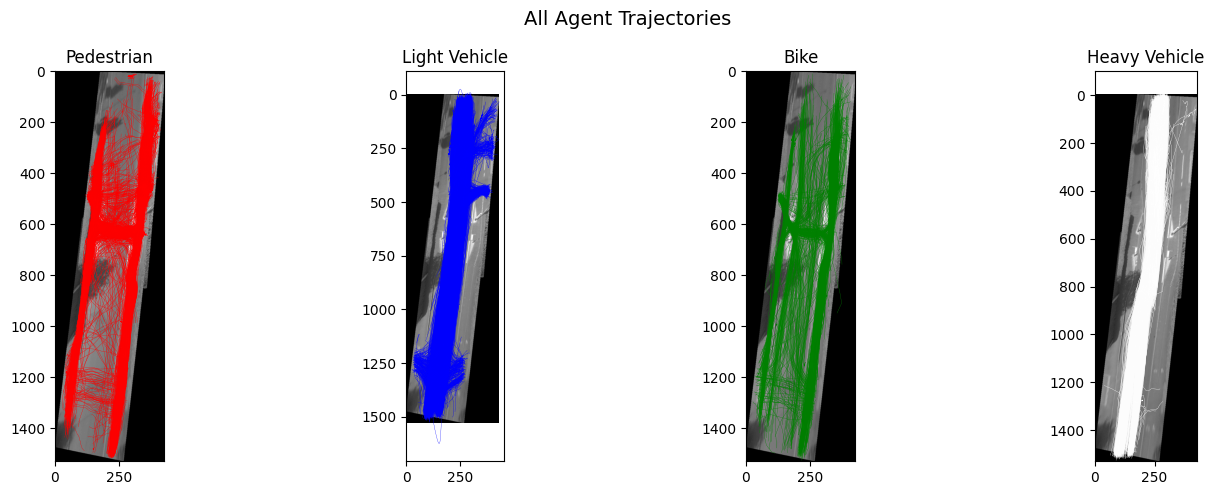

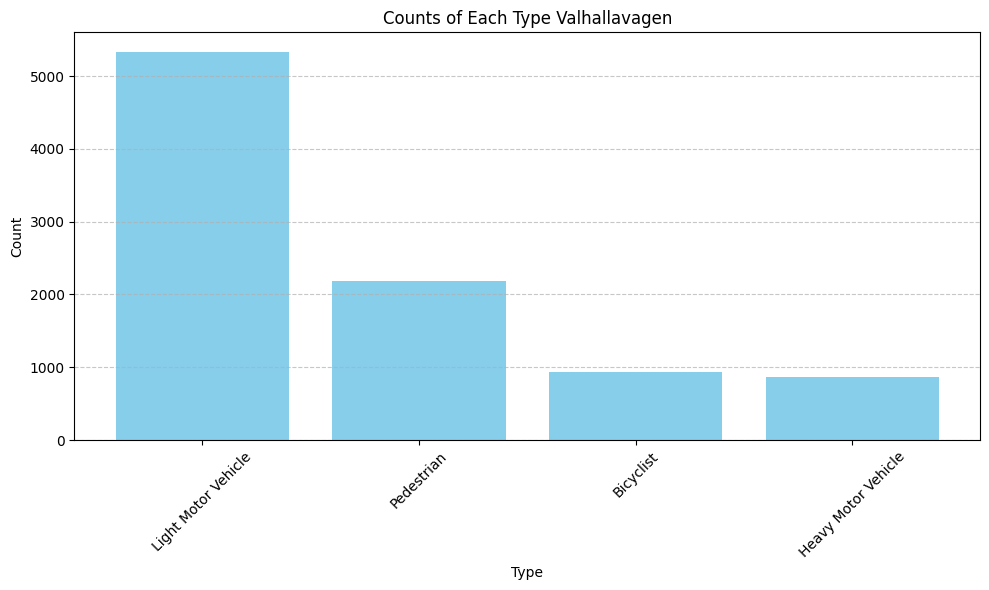

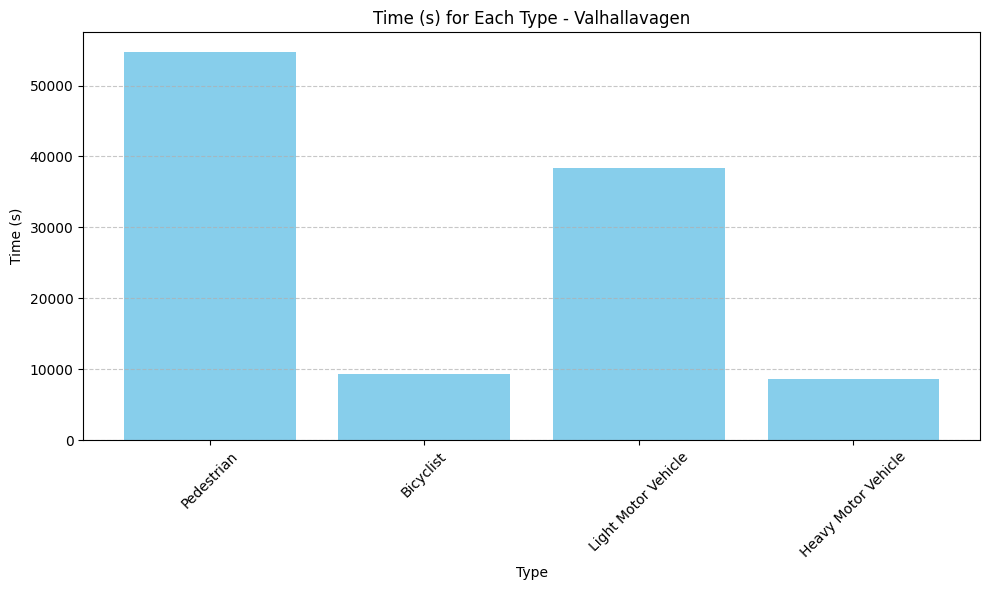

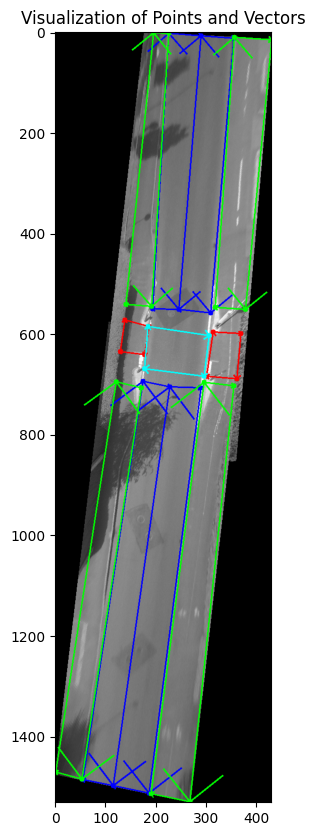

In [127]:
df = create_dataset(location_name, origin_X, origin_Y, scale_X, scale_y)
img = plt.imread(val_img)
visualize_all_trajectories(df, img, location_name)
visualize_counts(df, location_name)
visualize_time(df, location_name)
visualize_vectors(Valhallavagen_env_vectors, img_size_X, img_size_y, val_img, location_name)

In [128]:
dataset_length, embedding_dims = dataset_info(df, location_name)

In [ ]:
train_data, val_data, test_data = create_trajectory_dataset(
    df, 
    env_polygons=valhallavagen_ENV, 
    env_vectors=Valhallavagen_env_vectors, 
    static_objects=valhallavagen_static_objs,
    dataset_length=dataset_length,
    num_agents=embedding_dims[3], 
    src_len=10, 
    tgt_len=40, 
    location_name=location_name
    )


In [ ]:
save_tensor(train_data, "Train", location_name)
save_tensor(val_data, "Val", location_name)
save_tensor(test_data, "Test", location_name)

In [ ]:
create_timestamp_df(test_data, location_name)

In [ ]:
# Torpagatan preprocessing 
location_name = "Torpagatan"
size_X, size_Y, img_size_X, img_size_y, origin_X, origin_Y, scale_X, scale_y = get_location_values(Torpagatan_X_min, Torpagatan_X_max, Torpagatan_Y_min, Torpagatan_Y_max, torp_img)

In [ ]:
df = create_dataset(location_name, origin_X, origin_Y, scale_X, scale_y)
img = plt.imread(torp_img)
visualize_all_trajectories(df, img, location_name)
visualize_counts(df, location_name)
visualize_time(df, location_name)
visualize_vectors(Torpagatan_env_vectors, img_size_X, img_size_y, torp_img, location_name)

In [ ]:
dataset_length, embedding_dims = dataset_info(df, location_name)

In [ ]:
train_data, val_data, test_data = create_trajectory_dataset(
    df, 
    env_polygons=torpagatan_ENV, 
    env_vectors=Torpagatan_env_vectors, 
    static_objects=torpagatan_static_objs,
    dataset_length=dataset_length,
    num_agents=embedding_dims[3], 
    src_len=10, 
    tgt_len=40, 
    location_name=location_name
    )

In [ ]:
save_tensor(train_data, "Train", location_name)
save_tensor(val_data, "Val", location_name)
save_tensor(test_data, "Test", location_name)

In [ ]:
create_timestamp_df(test_data, location_name)